In [ ]:
# TENNIS BALL DETECTION. This approach seems the best.

import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
%matplotlib inline



# Define the range for the tennis ball color in HSV
lower_yellow_green = np.array([25, 70, 120])
upper_yellow_green = np.array([60, 255, 255])

# Start capturing video from the USB camera (usually index 1)
cap = cv2.VideoCapture(8)  # Try changing to 2, 3, etc., if 1 doesn't work

if not cap.isOpened():
    print("Error: Could not open USB camera.")
else:
    try:
        while True:
            # Capture frame-by-frame
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture image.")
                break

            # Convert the frame to the HSV color space
            hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

            # Create a mask for the tennis ball color
            mask = cv2.inRange(hsv, lower_yellow_green, upper_yellow_green)

            # Perform morphological operations to remove noise and improve detection
            kernel = np.ones((5, 5), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

            # Find contours
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Track the tennis ball by finding the largest contour
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                area = cv2.contourArea(largest_contour)
                if area > 300:  # Adjust the area threshold as needed
                    (x, y), radius = cv2.minEnclosingCircle(largest_contour)
                    center = (int(x), int(y))
                    radius = int(radius)

                    # Draw the circle and centroid on the frame
                    cv2.circle(frame, center, radius, (0, 255, 0), 4)
                    cv2.circle(frame, center, 5, (0, 128, 255), -1)

            # Display the resulting frame
    #         cv2.imshow("Tennis Ball Tracking", frame)
            #Show the image with matplotlib
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            display.clear_output(wait=True)
            plt.imshow(frame)
            plt.show()

            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    except KeyboardInterrupt:
        # Release the webcam and close windows
        cap.release()
        cv2.destroyAllWindows()


## Nadia's version of the tennis ball detection code above:
It works for longer distances but it's a lot more noisy. The tennis ball court has less objects than my room so I'm hoping there will be less false positives but otherwise we might have to go for the code above.

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
%matplotlib inline

# Expanded HSV range for washed-out tennis balls at a distance
lower_yellow_green = np.array([20, 40, 80])
upper_yellow_green = np.array([80, 255, 255])

# Start capturing video from the USB camera
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open USB camera.")
else:
    try:
        while True:
            # Capture frame-by-frame
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture image.")
                break

            # Apply a slight Gaussian blur to reduce noise
            blurred_frame = cv2.GaussianBlur(frame, (5, 5), 0)
            
            
            """normalisation"""
            # Convert the frame to the YUV color space
            yuv = cv2.cvtColor(blurred_frame, cv2.COLOR_BGR2YUV)

            # Equalize the histogram of the Y channel
            yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])

            # Convert the image back to BGR color space
            equalized_frame = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
            
            
            # Convert the frame to the HSV color space
            hsv = cv2.cvtColor(equalized_frame, cv2.COLOR_BGR2HSV)

            # Create a mask for the tennis ball color
            mask = cv2.inRange(hsv, lower_yellow_green, upper_yellow_green)

            # Perform morphological operations to remove noise and improve detection
            kernel = np.ones((5, 5), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            
            # Find contours
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Track the tennis ball by finding the largest contour
            if contours:
                for contour in contours:
                    area = cv2.contourArea(contour)
                    if area > 100:  # Reduced area threshold for smaller distant balls. Can reduce further and fine tune on court. 
                        perimeter = cv2.arcLength(contour, True)
                        circularity = 4 * np.pi * (area / (perimeter ** 2))

                        if circularity > 0.7:  # Enforce circularity check
                            (x, y), radius = cv2.minEnclosingCircle(contour)
                            center = (int(x), int(y))
                            radius = int(radius)

                            # Draw the circle and centroid on the frame
                            cv2.circle(frame, center, radius, (0, 255, 0), 2)
                            cv2.circle(frame, center, 5, (0, 128, 255), -1)

            # Display the resulting frame
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            display.clear_output(wait=True)
            plt.imshow(frame)
            plt.show()

            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    except KeyboardInterrupt:
        # Release the webcam and close windows
        cap.release()
        cv2.destroyAllWindows()


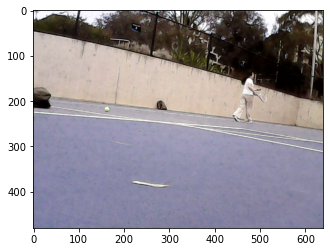

In [ ]:
"""Nadias code, with background subtraction and colour filtering from Claude AI"""

import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
%matplotlib inline

# Define multiple color ranges for different lighting conditions
color_ranges = [
    (np.array([20, 40, 80]), np.array([80, 255, 255])),  # Yellow-green
    (np.array([15, 30, 70]), np.array([85, 255, 255]))   # Broader range
]

# Start capturing video from the USB camera
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open USB camera.")
else:
    # Create background subtractor
    bg_subtractor = cv2.createBackgroundSubtractorMOG2(detectShadows=True)

    try:
        while True:
            # Capture frame-by-frame
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture image.")
                break

            # Apply a slight Gaussian blur to reduce noise
            blurred_frame = cv2.GaussianBlur(frame, (5, 5), 0)

            # Convert the frame to the HSV color space
            hsv = cv2.cvtColor(blurred_frame, cv2.COLOR_BGR2HSV)

            # Create a mask for the tennis ball color (combine multiple ranges)
            mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
            for lower, upper in color_ranges:
                mask |= cv2.inRange(hsv, lower, upper)

            # Apply background subtraction
            fg_mask = bg_subtractor.apply(frame)
            
            # Combine color mask with foreground mask
            combined_mask = cv2.bitwise_and(mask, fg_mask)

            # Perform morphological operations to remove noise and improve detection
            kernel = np.ones((5, 5), np.uint8)
            combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
            combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)

            # Find contours
            contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Track the tennis balls
            for contour in contours:
                area = cv2.contourArea(contour)
                if area > 100:  # Adjust this threshold as needed
                    perimeter = cv2.arcLength(contour, True)
                    circularity = 4 * np.pi * (area / (perimeter ** 2))
                    if circularity > 0.7:  # Enforce circularity check
                        (x, y), radius = cv2.minEnclosingCircle(contour)
                        center = (int(x), int(y))
                        radius = int(radius)
                        # Draw the circle and centroid on the frame
                        cv2.circle(frame, center, radius, (0, 255, 0), 2)
                        cv2.circle(frame, center, 5, (0, 128, 255), -1)

            # Display the resulting frame
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            display.clear_output(wait=True)
            plt.imshow(frame_rgb)
            plt.show()

            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    except KeyboardInterrupt:
        pass

    # Release the webcam and close windows
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
"""
NADIAS CODE, NO NORMALISATION
"""

import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
%matplotlib inline

# Expanded HSV range for washed-out tennis balls at a distance
lower_yellow_green = np.array([20, 40, 80])
upper_yellow_green = np.array([80, 255, 255])

# Start capturing video from the USB camera
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open USB camera.")
else:
    try:
        while True:
            # Capture frame-by-frame
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture image.")
                break

            # Apply a slight Gaussian blur to reduce noise
            blurred_frame = cv2.GaussianBlur(frame, (5, 5), 0)
            
            
            """no normalisation"""

            
            # Convert the frame to the HSV color space
            hsv = cv2.cvtColor(blurred_frame, cv2.COLOR_BGR2HSV)

            # Create a mask for the tennis ball color
            mask = cv2.inRange(hsv, lower_yellow_green, upper_yellow_green)

            # Perform morphological operations to remove noise and improve detection
            kernel = np.ones((5, 5), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            
            # Find contours
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Track the tennis ball by finding the largest contour
            if contours:
                for contour in contours:
                    area = cv2.contourArea(contour)
                    if area > 100:  # Reduced area threshold for smaller distant balls. Can reduce further and fine tune on court. 
                        perimeter = cv2.arcLength(contour, True)
                        circularity = 4 * np.pi * (area / (perimeter ** 2))

                        if circularity > 0.7:  # Enforce circularity check
                            (x, y), radius = cv2.minEnclosingCircle(contour)
                            center = (int(x), int(y))
                            radius = int(radius)

                            # Draw the circle and centroid on the frame
                            cv2.circle(frame, center, radius, (0, 255, 0), 2)
                            cv2.circle(frame, center, 5, (0, 128, 255), -1)

            # Display the resulting frame
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            display.clear_output(wait=True)
            plt.imshow(frame)
            plt.show()

            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    except KeyboardInterrupt:
        # Release the webcam and close windows
        cap.release()
        cv2.destroyAllWindows()


In [ ]:
# Find a valid camera indice
import os
devs = os.listdir('/dev')
vid_indices = [int(dev[-1]) for dev in devs 
               if dev.startswith('video')]
vid_indices = sorted(vid_indices)
vid_indices

In [ ]:
# TENNIS BALL DETECTION, HOUGH CIRCLES

import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
%matplotlib inline




# Define the range for the tennis ball color in HSV
lower_yellow_green = np.array([25, 70, 120])
upper_yellow_green = np.array([60, 255, 255])

# Start capturing video from the USB camera (usually index 1)
cap = cv2.VideoCapture(0)  # Try changing to 2, 3, etc., if 1 doesn't work

if not cap.isOpened():
    print("Error: Could not open USB camera.")
else:
    try:
        while True:
            # Capture frame-by-frame
            ret, image = cap.read()
            if not ret:
                print("Error: Failed to capture image.")
                break


            # Convert the image to the HSV color space
            hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

            # Define the flexible range for the tennis ball color (morning and afternoon)
            lower_yellow_green = np.array([20, 50, 60])
            upper_yellow_green = np.array([60, 255, 255])

            # Create a mask for the tennis ball color
            mask = cv2.inRange(hsv, lower_yellow_green, upper_yellow_green)

            # Apply the mask to get the yellow-green parts of the image
            masked_image = cv2.bitwise_and(image, image, mask=mask)

            # Convert the masked image to grayscale
            gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

            # Apply Gaussian blur to the grayscale image
            gray_blurred = cv2.GaussianBlur(gray, (9, 9), 2)

            # Use the HoughCircles function to detect circles
            circles = cv2.HoughCircles(
                gray_blurred, 
                cv2.HOUGH_GRADIENT, dp=1.2, minDist=30, 
                param1=100, param2=30, minRadius=15, maxRadius=50
            )

            # Ensure at least some circles were found
            if circles is not None:
                # Convert the (x, y) coordinates and radius of the circles to integers
                circles = np.round(circles[0, :]).astype("int")

                # Loop over the circles and draw them on the image
                for (x, y, r) in circles:
                    cv2.circle(image, (x, y), r, (0, 255, 0), 4)
                    cv2.rectangle(image, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
            
            frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            display.clear_output(wait=True)
            plt.imshow(frame)
            plt.show()

            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    except KeyboardInterrupt:
        # Release the webcam and close windows
        cap.release()
        cv2.destroyAllWindows()

In [ ]:
# Line Detection Code HERE
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
%matplotlib inline


# Tennis Ball Deteciton

# Define the range for the tennis ball color in HSV
lower_yellow_green = np.array([25, 70, 120])
upper_yellow_green = np.array([60, 255, 255])

# Start capturing video from the USB camera (usually index 1)
cap = cv2.VideoCapture(0)  # Try changing to 2, 3, etc., if 1 doesn't work

if not cap.isOpened():
    print("Error: Could not open USB camera.")
else:
    try:
        while True:
            # Capture frame-by-frame
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture image.")
                break


            # Grayscale conversion
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Canny edge detection
            edges = cv2.Canny(gray, 150, 160, apertureSize=3)

            # Hough Line Transform
            lines = cv2.HoughLines(edges, 1.5, np.pi / 180, 200)

            # Iterate through each detected line
            for line in lines:
                rho, theta = line[0]
                # Convert polar coordinates to Cartesian coordinates
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                y0 = b * rho
                x1 = int(x0 + 1000 * (-b))
                y1 = int(y0 + 1000 * (a))
                x2 = int(x0 - 1000 * (-b))
                y2 = int(y0 - 1000 * (a))

                # Draw lines on the original image
                cv2.line(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)


            # Display the resulting frame
    #         cv2.imshow("Tennis Ball Tracking", frame)
            #Show the image with matplotlib
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            display.clear_output(wait=True)
            plt.imshow(frame)
            plt.show()

            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    except KeyboardInterrupt:
        # Release the webcam and close windows
        cap.release()
        cv2.destroyAllWindows()

        
        
        

    # Grayscale conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Canny edge detection
    edges = cv2.Canny(gray, 150, 160, apertureSize=3)

    # Hough Line Transform
    lines = cv2.HoughLines(edges, 1.5, np.pi / 180, 200)

    # Iterate through each detected line
    for line in lines:
        rho, theta = line[0]
        # Convert polar coordinates to Cartesian coordinates
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        # Draw lines on the original image
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)



In [ ]:
import numpy as np
from time import time
# class Camera:
#     def __init__(self, camera_index=0):
#         self.cap = cv2.VideoCapture(camera_index)
#         self.last_frame = None
#         self.last_scanned_time = None
#     
#     def capture_frame(self):
#         ret, frame = self.cap.read()
#         if ret:
#             self.last_frame = frame
#             self.last_scanned_time = time()
#         return ret, frame
# 
#     def release(self):
#         self.cap.release()
#         cv2.destroyAllWindows()

    
        
    
class TennisBallDetector:
    def __init__(self, lower_color=(20, 100, 100), upper_color=(40, 255, 255), min_radius=10, max_radius=50, min_area=1000):
        self.camera = None
        self.camera_indice = 0 # Try changing to 1, 2, 3, etc., if 0 doesn't work
        self.lower_color = np.array(lower_color)
        self.upper_color = np.array(upper_color)
        self.min_radius = min_radius
        self.max_radius = max_radius
        self.min_area = min_area
        self.balls = []
        self.frame_center = None
        self.last_scanned_time = None
        self.kernel = np.ones((5, 5), np.uint8)
        
        if not cap.isOpened():
            print("Error: Could not open USB camera.")

    def detect(self, frame=None):
        if not camera:
            self.camera = cv2.VideoCapture(self.camera_indice)  
        if not frame:
            ret, frame = self.camera.read()
            if not ret:
                print("Error: Failed to capture image.")
                return
        self.last_scanned_time = time()
        self.frame_center = (frame.shape[1] // 2, frame.shape[0] // 2)
        
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, self.lower_color, self.upper_color)

        # Perform morphological operations
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, self.kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, self.kernel)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        self.balls = []

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > self.min_area:
                ((x, y), radius) = cv2.minEnclosingCircle(contour)
                if self.min_radius < radius < self.max_radius:
                    self.balls.append(((int(x), int(y)), int(radius)))

        # Sort balls by size (largest first) if multiple balls are detected
        self.balls.sort(key=lambda ball: ball[1], reverse=True)

    def get_ball_count(self):
        return len(self.balls)

    def get_ball_locations(self):
        return [ball[0] for ball in self.balls]

    def get_ball_distance_from_center(self, ball_index):
        if 0 <= ball_index < len(self.balls):
            ball_center = self.balls[ball_index][0]
            dx = ball_center[0] - self.frame_center[0]
            dy = ball_center[1] - self.frame_center[1]
            distance_pixels = np.sqrt(dx**2 + dy**2)
            angle_radians = np.arctan2(dy, dx)
            return distance_pixels, angle_radians
        else:
            return None

    def draw_balls(self, frame):
        for i, (center, radius) in enumerate(self.balls):
            color = (0, 255, 0) if i == 0 else (0, 255, 255)  # Green for largest, Yellow for others
            cv2.circle(frame, center, radius, color, 2)
            cv2.circle(frame, center, 5, (0, 0, 255), -1)
        return frame

    def get_last_scanned_time(self):
        return self.last_scanned_time






if __name__ == "__main__":
    detector = TennisBallDetector()
    cap = cv2.VideoCapture(0)  # Use 0 for default camera

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        detector.detect(frame)
        frame = detector.draw_balls(frame)

        print(f"Number of tennis balls: {detector.get_ball_count()}")
        print(f"Ball locations: {detector.get_ball_locations()}")
        print(f"Last scanned time: {detector.get_last_scanned_time():.2f}")

        if detector.get_ball_count() > 0:
            distance, angle = detector.get_ball_distance_from_center(0)
            print(f"Distance of largest ball from center: {distance:.2f} pixels")
            print(f"Angle of largest ball from center: {angle:.2f} radians")

        cv2.imshow('Tennis Ball Detector', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np
from time import time
from IPython import display
from matplotlib import pyplot as plt


class TennisBallDetector:
    def __init__(self, lower_color=(20, 100, 100), upper_color=(40, 255, 255), min_radius=10, max_radius=50, min_area=1000, line_distance=100):
        self.camera = cv2.VideoCapture(0)  # Try changing to 2, 3, etc., if 1 doesn't work
        self.lower_color = np.array(lower_color)
        self.upper_color = np.array(upper_color)
        self.min_radius = min_radius
        self.max_radius = max_radius
        self.min_area = min_area
        self.balls = []
        self.frame_center = None
        self.last_scanned_time = None
        self.kernel = np.ones((5, 5), np.uint8)
        self.line_distance = line_distance
        self.frame = None
        
        if not self.camera.isOpened():
            print("Error: Could not open USB camera.")

    def detect(self, retry=True, max_num_retries=10, retry_interval=1):
        counter = 0
        
        while counter < max_num_retries:

            ret, self.frame = self.camera.read()
            if not ret:
                print("Error: Failed to capture image.")
                return
            self.last_scanned_time = time()
            self.frame_center = (self.frame.shape[1] // 2, self.frame.shape[0] // 2)

            hsv = cv2.cvtColor(self.frame, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(hsv, self.lower_color, self.upper_color)

            # Perform morphological operations
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, self.kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, self.kernel)

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            self.balls = []

            for contour in contours:
                area = cv2.contourArea(contour)
                if area > self.min_area:
                    ((x, y), radius) = cv2.minEnclosingCircle(contour)
                    if self.min_radius < radius < self.max_radius:
                        self.balls.append(((int(x), int(y)), int(radius)))

            # Sort balls by size (largest first) if multiple balls are detected
            self.balls.sort(key=lambda ball: ball[1], reverse=True)
            if len(self.balls) > 0:
                return True
            else:
                counter += 1
        return False

    def get_ball_count(self):
        return len(self.balls)

    def get_ball_locations(self):
        return [ball[0] for ball in self.balls]

    def get_ball_distance_from_center(self, ball_index):
        if 0 <= ball_index < len(self.balls):
            ball_center = self.balls[ball_index][0]
            dx = ball_center[0] - self.frame_center[0]
            dy = ball_center[1] - self.frame_center[1]
            distance_pixels = np.sqrt(dx**2 + dy**2)
            angle_radians = np.arctan2(dy, dx)
            return distance_pixels, angle_radians
        else:
            return None

    def draw_balls(self, frame=None):
        if not frame:
            frame = self.frame
        for i, (center, radius) in enumerate(self.balls):
            color = (0, 255, 0) if i == 0 else (0, 255, 255)  # Green for largest, Yellow for others
            cv2.circle(frame, center, radius, color, 2)
            cv2.circle(frame, center, 5, (0, 0, 255), -1)
        return frame

    def get_last_scanned_time(self):
        return self.last_scanned_time

    def draw_vertical_lines(self, frame=None):
        if not frame:
            frame = self.frame
        height, width = frame.shape[:2]
        left_x = width // 2 - self.line_distance // 2
        right_x = width // 2 + self.line_distance // 2
        
        cv2.line(frame, (left_x, 0), (left_x, height), (255, 0, 0), 2)
        cv2.line(frame, (right_x, 0), (right_x, height), (255, 0, 0), 2)
        
        return frame

    def is_ball_between_lines(self, ball_index=0):
        if 0 <= ball_index < len(self.balls):
            ball_center, ball_radius = self.balls[ball_index]
            height, width = self.camera.get(cv2.CAP_PROP_FRAME_HEIGHT), self.camera.get(cv2.CAP_PROP_FRAME_WIDTH)
            left_x = width // 2 - self.line_distance // 2
            right_x = width // 2 + self.line_distance // 2
            
            # Check if the entire ball is between the lines
            return (left_x <= ball_center[0] - ball_radius) and (ball_center[0] + ball_radius <= right_x)
        else:
            return False

    # returns tennis ball distance from center lines. -ve means on left. +ve means on right.
    def get_ball_distance_from_lines(self, ball_index=0):
        if 0 <= ball_index < len(self.balls):
            ball_center, _ = self.balls[ball_index]
            height, width = self.camera.get(cv2.CAP_PROP_FRAME_HEIGHT), self.camera.get(cv2.CAP_PROP_FRAME_WIDTH)
            left_x = width // 2 - self.line_distance // 2
            right_x = width // 2 + self.line_distance // 2
            
            if ball_center[0] < left_x:
                return -(left_x - ball_center[0])
            elif ball_center[0] > right_x:
                return ball_center[0] - right_x
            else:
                return 0  # Ball is between the lines
        else:
            return None

    def set_line_distance(self, distance):
        self.line_distance = distance

detector = TennisBallDetector(line_distance=150)




In [ ]:
detector.detect()
frame = detector.draw_balls()
frame = detector.draw_vertical_lines()

# frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
display.clear_output(wait=True)
plt.imshow(frame)
plt.show()


if detector.get_ball_count() > 0:
    is_between = detector.is_ball_between_lines()
    distance = detector.get_ball_distance_from_lines()
    print(f"Ball between lines: {is_between}")
    print(f"Distance from nearest line: {distance}")